In [1]:
## load required libraries
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch 

import relso
from relso import data as hdata
from relso.utils import model_utils
from relso.nn.models import relso1


%matplotlib inline

In [2]:
import pandas as pd

### Load the data

In [3]:
data = pd.read_csv('clean_data.csv')
data.shape

(5503, 24)

In [4]:
unique_values = data['Epitope - Name'].unique()
len(unique_values)

4451

In [5]:
sequences = list(unique_values)

In [6]:
data = data.drop_duplicates(subset=['Epitope - Name'])
data.shape

(4451, 24)

In [7]:
assay_values = torch.tensor(data['Assay - Qualitative Measure'].values, dtype=torch.float32)

### Load model

In [8]:
# path to weights
relso_weight_path = model_utils.weight_path_from_json(json_path='../hws/ReLSO-Guided-Generative-Protein-Design-using-Regularized-Transformers/relso_model_weights/trained_models.json',
                           weight_dir='../hws/ReLSO-Guided-Generative-Protein-Design-using-Regularized-Transformers/relso_model_weights/trained_models',
                          dataset='gifford',
                          model='all')
print(relso_weight_path)

../hws/ReLSO-Guided-Generative-Protein-Design-using-Regularized-Transformers/relso_model_weights/trained_models/2021-06-22-16-59-23_model_weights.ckpt


In [9]:
relso_model = relso1.load_from_checkpoint(relso_weight_path)
relso_model = relso_model.eval()

/home/cpsc477_nb752/.conda/envs/cpsc552/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.0.3 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ReLSO-Guided-Generative-Protein-Design-using-Regularized-Transformers/relso_model_weights/trained_models/2021-06-22-16-59-23_model_weights.ckpt`


[Linear(in_features=30, out_features=4000, bias=True), Block(
  (skip): Sequential(
    (0): Conv1d(200, 400, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block): Sequential(
    (0): Conv1d(200, 400, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(400, 400, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
), Conv1d(400, 22, kernel_size=(3,), stride=(1,), padding=(1,))]


### Generate embeddings

In [10]:
def encode_amino_acids(sequence, max_length=20):
    mapping = {aa: idx for idx, aa in enumerate('ACDEFGHIKLMNPQRSTVWY', 1)}
    encoded_sequence = [mapping.get(aa, 0) for aa in sequence]
    padded_sequence = encoded_sequence + [0] * (max_length - len(encoded_sequence))
    return padded_sequence[:max_length]

# Apply encoding and padding to each sequence
max_length = 20
encoded_sequences = [encode_amino_acids(seq, max_length) for seq in sequences]

# Convert list of amino acid indices to tensor
sequence_tensors = torch.tensor(encoded_sequences, dtype=torch.long)
print(sequence_tensors)
sequence_tensors.shape

tensor([[13, 17, 15,  ...,  9,  8,  4],
        [ 4, 15,  9,  ...,  0,  0,  0],
        [ 1,  4,  4,  ...,  0,  0,  0],
        ...,
        [ 6, 10, 20,  ...,  0,  0,  0],
        [10, 17, 12,  ...,  0,  0,  0],
        [16,  2, 20,  ...,  0,  0,  0]])


torch.Size([4451, 20])

In [11]:
import torch
import tqdm

# Assuming sequence_tensors and relso_model are defined
embeddings = []
for sequence_tensor in tqdm.tqdm(sequence_tensors, desc="Generating Embeddings"):
    with torch.no_grad():
        output = relso_model(sequence_tensor.unsqueeze(0))  # Add batch dimension

    # Handle different types of outputs
    if isinstance(output, tuple):
        main_output = output[0][0]  # Remove batch dimension
    elif isinstance(output, torch.Tensor):
        main_output = output.squeeze(0)  # Remove batch dimension if not done yet
    else:
        raise TypeError("Output is not a tensor")

    # Flatten or average the output to 1D per sequence
    if len(main_output.shape) > 1:  # Check if there are multiple dimensions to reduce
        flattened_output = main_output.flatten()

    embeddings.append(flattened_output)

# Concatenate all embeddings to form a 2D tensor
embeddings_tensor = torch.stack(embeddings, dim=0)
print(embeddings_tensor.shape)

Generating Embeddings: 100%|██████████| 4451/4451 [00:34<00:00, 127.94it/s]

torch.Size([4451, 440])


In [12]:
embeddings_tensor

tensor([[ -7.4464, -10.9072, -12.6201,  ..., -47.9110,  -4.9777,   9.0472],
        [ -7.0585,  -7.5537,  -5.3427,  ..., -51.4940,   5.3583,  13.5966],
        [ -4.7640,  -6.5036,  -4.4864,  ..., -48.4916,   2.5750,  12.2470],
        ...,
        [ -7.0047,  -7.0775,  -7.8137,  ..., -51.0694,   6.1859,  13.8618],
        [ -7.4029,  -7.2875,  -7.2530,  ..., -52.6248,   7.0108,  14.7933],
        [ -7.5529,  -7.3469,  -8.2677,  ..., -51.7463,   4.6596,  13.0522]])

### Classification architecture

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
class BinaryPredictionModel(nn.Module):
    def __init__(self, embedding_dim, sequence_length):
        super(BinaryPredictionModel, self).__init__()
        
        # Parameters
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the size after pooling
        reduced_length = sequence_length // 4
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * reduced_length, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, embeddings):
        # Assume embeddings are of shape (batch_size, 440)
        # Reshape to (batch_size, embedding_dim, sequence_length)
        embeddings = embeddings.view(-1, self.embedding_dim, self.sequence_length).permute(0, 1, 2)
        
        # Convolutional layers
        conv_out1 = self.conv1(embeddings)
        conv_out1 = self.relu(conv_out1)
        conv_out1 = self.pool(conv_out1)
        
        conv_out2 = self.conv2(conv_out1)
        conv_out2 = self.relu(conv_out2)
        conv_out2 = self.pool(conv_out2)
        
        # Flatten convolutional output
        conv_out2 = conv_out2.view(-1, 128 * (self.sequence_length // 4))
        
        # Fully connected layers
        fc_out1 = self.fc1(conv_out2)
        fc_out1 = self.relu(fc_out1)
        fc_out2 = self.fc2(fc_out1)
        output = self.sigmoid(fc_out2)
        
        return output

In [15]:
# Instantiate the model
embedding_dim = 20  # the embedding dimension is 20
max_length = 22     # Maximum length of the sequences
model = BinaryPredictionModel(embedding_dim, max_length)

### Training and Evaluation

In [16]:
from sklearn.metrics import roc_auc_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import tqdm

In [17]:
# Define your loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Convert embeddings tensor to float32
embeddings_tensor = embeddings_tensor.float()

dataset = TensorDataset(embeddings_tensor, assay_values)
# Split dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

batch_size = 8

# Create DataLoader for training set
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
# Create DataLoader for validation set
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [19]:
# Training loop
num_epochs = 100
training_loss_list = []
training_acc_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        labels = labels.unsqueeze(1).float()  # Ensure labels are float and match output shape
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate training accuracy (appropriate for binary classification)
        predicted = (outputs > 0.5).float()  # Using a threshold of 0.5
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    training_loss_list.append(epoch_loss)
    training_acc_list.append(epoch_accuracy)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training finished')

Epoch 1, Loss: 0.5231, Accuracy: 0.7761
Epoch 6, Loss: 0.4735, Accuracy: 0.7921
Epoch 11, Loss: 0.4508, Accuracy: 0.8093
Epoch 16, Loss: 0.4343, Accuracy: 0.8233
Epoch 21, Loss: 0.4199, Accuracy: 0.8177
Epoch 26, Loss: 0.3961, Accuracy: 0.8407
Epoch 31, Loss: 0.3742, Accuracy: 0.8500
Epoch 36, Loss: 0.3477, Accuracy: 0.8629
Epoch 41, Loss: 0.3117, Accuracy: 0.8795
Epoch 46, Loss: 0.2891, Accuracy: 0.8896
Epoch 51, Loss: 0.2851, Accuracy: 0.8969
Epoch 56, Loss: 0.2326, Accuracy: 0.9157
Epoch 61, Loss: 0.2239, Accuracy: 0.9185
Epoch 66, Loss: 0.1873, Accuracy: 0.9385
Epoch 71, Loss: 0.2282, Accuracy: 0.9194
Epoch 76, Loss: 0.2075, Accuracy: 0.9261
Epoch 81, Loss: 0.1767, Accuracy: 0.9419
Epoch 86, Loss: 0.1703, Accuracy: 0.9416
Epoch 91, Loss: 0.1704, Accuracy: 0.9368
Epoch 96, Loss: 0.2081, Accuracy: 0.9317
Training finished


Text(0.5, 0, 'Epochs')

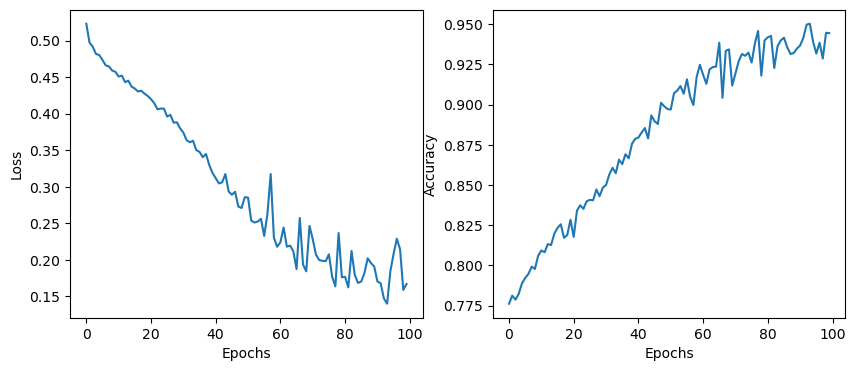

In [20]:
# plot loss vs epochs
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(num_epochs), training_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(num_epochs), training_acc_list)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')

In [21]:
from sklearn.metrics import roc_auc_score, f1_score

# Evaluation function
def evaluate(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_preds = []  # This will store the probabilities for ROC AUC calculation

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predicted_probs = outputs.squeeze(1)  # Get probabilities from model output
            predicted_labels = (predicted_probs > 0.5).float()  # Convert probabilities to 0 or 1 based on threshold

            # Calculate correct predictions for accuracy
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            # Store labels and predictions for computing ROC AUC and F1 Score
            all_labels.extend(labels.tolist())
            all_preds.extend(predicted_probs.tolist())  # Use probabilities for ROC AUC

    accuracy = correct_predictions / total_samples
    roc_auc = roc_auc_score(all_labels, all_preds)  # Use probabilities for ROC AUC calculation
    f1 = f1_score(all_labels, [1 if x > 0.5 else 0 for x in all_preds])  # Convert probabilities to labels for F1

    return accuracy, roc_auc, f1

# Perform validation
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.7980
ROC AUC Score: 0.6532
F1 Score: 0.4972


### With Biological Information

In [22]:
columns_to_drop = ['Epitope - Name', 'Assay - Qualitative Measure', 'Epitope - Object Type']
data2 = data.drop(columns=columns_to_drop)
data2.head()

,Epitope - Starting Position,Epitope - Ending Position,Epitope - Source Molecule,Epitope - Source Organism,Host - Name,Host - Age,1st in vivo Process - Process Type,1st in vivo Process - Disease,1st in vivo Process - Disease Stage,Adoptive Transfer - Flag,...,Assay - Response measured,Assay - Response Frequency (%),Assay Antibody - Antibody Source Material,Assay Antibody - Immunoglobulin Domain,Assay Antibody - Purification Status,Assay Antibody - Heavy chain isotype,Assay Antigen - Epitope Relation,Assay Antigen - Object Type,Assay Antigen - Source Organism,Assay Antigen - Species
0,57.0,76.0,U1 small nuclear ribonucleoprotein 70 kDa,Homo sapiens,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,systemic lupus erythematosus,Chronic,0,...,qualitative binding,NaN,Serum,NaN,Polyclonal,NaN,Epitope,Linear peptide,Homo sapiens,Homo sapiens
1,68.0,72.0,U1 small nuclear ribonucleoprotein 70 kDa,Homo sapiens,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,systemic lupus erythematosus,Chronic,0,...,qualitative binding,NaN,Serum,NaN,Polyclonal,NaN,Epitope,Linear peptide,Homo sapiens,Homo sapiens
3,93.0,107.0,ribosomal protein P-JL5,Trypanosoma cruzi,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,systemic lupus erythematosus,Unknown,0,...,qualitative binding,100.0,Serum,Entire Antibody,Polyclonal,IgG,Epitope,Linear peptide,Trypanosoma cruzi,Trypanosoma cruzi
4,73.0,91.0,ribosomal protein P-JL5,Trypanosoma cruzi,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,systemic lupus erythematosus,Unknown,0,...,qualitative binding,0.0,Serum,Entire Antibody,Polyclonal,IgG,Epitope,Linear peptide,Trypanosoma cruzi,Trypanosoma cruzi
5,95.0,107.0,ribosomal protein P-JL5,Trypanosoma cruzi,Homo sapiens,Seniors (65+ years),Occurrence of autoimmune disease,systemic lupus erythematosus,Unknown,0,...,qualitative binding,NaN,Serum,Entire Antibody,Polyclonal,NaN,Epitope,Linear peptide,Trypanosoma cruzi,Trypanosoma cruzi


In [23]:
# Separating categorical and continuous variables
categorical_cols = [col for col in data2.columns if data2[col].dtype == 'object' or data2[col].dtype.name == 'category']
numerical_cols = [col for col in data2.columns if data2[col].dtype in ['int64', 'float64'] and col not in categorical_cols]

# Print out the lists
print("Categorical columns:", categorical_cols)
print()
print("Continuous columns:", numerical_cols)

Categorical columns: ['Epitope - Source Molecule', 'Epitope - Source Organism', 'Host - Name', 'Host - Age', '1st in vivo Process - Process Type', '1st in vivo Process - Disease', '1st in vivo Process - Disease Stage', 'Assay - Method', 'Assay - Response measured', 'Assay Antibody - Antibody Source Material', 'Assay Antibody - Immunoglobulin Domain', 'Assay Antibody - Purification Status', 'Assay Antibody - Heavy chain isotype', 'Assay Antigen - Epitope Relation', 'Assay Antigen - Object Type', 'Assay Antigen - Source Organism', 'Assay Antigen - Species']

Continuous columns: ['Epitope - Starting Position', 'Epitope - Ending Position', 'Adoptive Transfer - Flag', 'Assay - Response Frequency (%)']


In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Impute missing values for numerical data
imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

# One-hot encode categorical data
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = encoder.fit_transform(data[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded categorical data with original DataFrame
data2 = pd.concat([data2, encoded_categorical_df], axis=1)

In [25]:
class ExtendedBinaryPredictionModel(nn.Module):
    def __init__(self, embedding_dim, sequence_length, additional_features_dim):
        super(ExtendedBinaryPredictionModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.additional_features_dim = additional_features_dim
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate reduced length after pooling
        reduced_length = sequence_length // 4
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * reduced_length + additional_features_dim, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, embeddings, additional_features):
        # Convolutional layers
        embeddings = embeddings.view(-1, self.embedding_dim, self.sequence_length).permute(0, 1, 2)
        conv_out1 = self.pool(self.relu(self.conv1(embeddings)))
        conv_out2 = self.pool(self.relu(self.conv2(conv_out1)))
        
        # Flatten convolutional output
        conv_out_flat = conv_out2.view(-1, 128 * (self.sequence_length // 4))
        
        # Concatenate additional features
        combined_input = torch.cat([conv_out_flat, additional_features], dim=1)
        
        # Fully connected layers
        fc_out1 = self.relu(self.fc1(combined_input))
        output = self.sigmoid(self.fc2(fc_out1))
        
        return output

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import train_test_split

# Convert additional features DataFrame to a tensor
additional_features_tensor = torch.tensor(encoded_categorical_df.values, dtype=torch.float32)

# Assume assay_values and embeddings_tensor are defined as before
dataset = TensorDataset(embeddings_tensor, additional_features_tensor, assay_values)

# Split dataset into training and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

batch_size = 8

# Create DataLoaders for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [27]:
import torch.nn as nn
import torch.optim as optim

# The additional_features_dim should match the number of columns in encoded_categorical_df
additional_features_dim = encoded_categorical_df.shape[1]
embedding_dim = 20  # Placeholder for the dimension of each embedding
sequence_length = 22  # Placeholder for the length of sequences considered by conv layers

# Instantiate the model
model = ExtendedBinaryPredictionModel(embedding_dim, sequence_length, additional_features_dim)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        inputs, features, labels = batch

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, features)

        # Compute the loss
        labels = labels.unsqueeze(1).float()  # Ensure labels are float and match output shape
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs > 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training finished')

Epoch 1, Loss: 0.3964, Accuracy: 0.8346
Epoch 6, Loss: 0.2431, Accuracy: 0.9011
Epoch 11, Loss: 0.2212, Accuracy: 0.9101
Epoch 16, Loss: 0.2164, Accuracy: 0.9098
Epoch 21, Loss: 0.2064, Accuracy: 0.9104
Epoch 26, Loss: 0.2051, Accuracy: 0.9129
Epoch 31, Loss: 0.1976, Accuracy: 0.9199
Epoch 36, Loss: 0.1904, Accuracy: 0.9180
Epoch 41, Loss: 0.1885, Accuracy: 0.9202
Epoch 46, Loss: 0.1855, Accuracy: 0.9244
Epoch 51, Loss: 0.1798, Accuracy: 0.9275
Epoch 56, Loss: 0.1750, Accuracy: 0.9301
Epoch 61, Loss: 0.1708, Accuracy: 0.9329
Epoch 66, Loss: 0.1656, Accuracy: 0.9315
Epoch 71, Loss: 0.1648, Accuracy: 0.9357
Epoch 76, Loss: 0.1589, Accuracy: 0.9388
Epoch 81, Loss: 0.2192, Accuracy: 0.9427
Epoch 86, Loss: 0.1522, Accuracy: 0.9430
Epoch 91, Loss: 0.1459, Accuracy: 0.9441
Epoch 96, Loss: 0.1470, Accuracy: 0.9452
Training finished


Text(0.5, 0, 'Epochs')

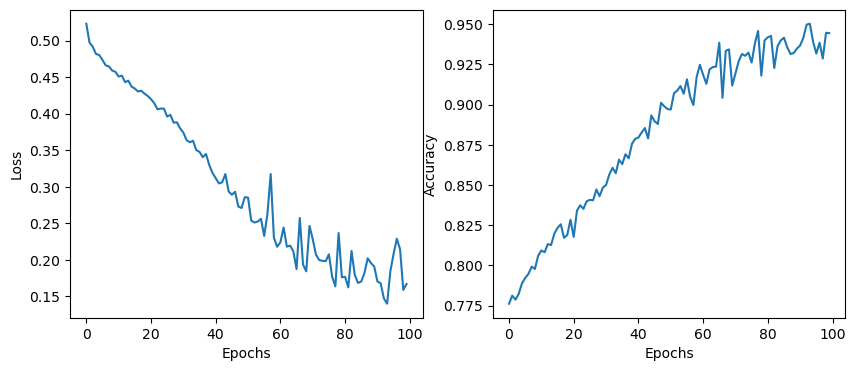

In [29]:
# plot loss vs epochs
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(num_epochs), training_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(num_epochs), training_acc_list)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')

In [31]:
from sklearn.metrics import roc_auc_score, f1_score

def evaluate(model, dataloader):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_preds = []  # This will store the probabilities for ROC AUC calculation

    with torch.no_grad():
        for batch in dataloader:
            inputs, features, labels = batch
            outputs = model(inputs, features).squeeze(1)  # Adjust for the model's forward method
            predicted_probs = outputs  # Directly use outputs as probabilities
            predicted_labels = (predicted_probs > 0.5).float()  # Convert probabilities to 0 or 1 based on threshold

            # Calculate correct predictions for accuracy
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

            # Store labels and predictions for computing ROC AUC and F1 Score
            all_labels.extend(labels.tolist())
            all_preds.extend(predicted_probs.tolist())  # Use probabilities for ROC AUC

    accuracy = correct_predictions / total_samples
    roc_auc = roc_auc_score(all_labels, all_preds)  # Use probabilities for ROC AUC calculation
    f1 = f1_score(all_labels, [1 if x > 0.5 else 0 for x in all_preds])  # Convert probabilities to labels for F1

    return accuracy, roc_auc, f1

# Perform validation
val_accuracy, val_roc_auc, val_f1 = evaluate(model, val_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'ROC AUC Score: {val_roc_auc:.4f}')
print(f'F1 Score: {val_f1:.4f}')

Validation Accuracy: 0.8934
ROC AUC Score: 0.9252
F1 Score: 0.7619
